# AE4350 - Bio-inspired Intelligence and Learning Assignment
This is the Main notebook for training and testing the DRL portfolio management system
<br>Created on Thu May 12 13:22:50 2022
<br>@author: Reinier Vos, 4663160-TUD

In [1]:
try:
    from utility_v9 import Agent, UtilFuncs, Statistics
except:
    pass
try:
    from AE4350_Assignment.utility_v9 import Agent, UtilFuncs, Statistics
except:
    pass
import sys
from tqdm import tqdm
from tqdm.notebook import trange
import os
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
#In TensorFlow 2.3+, you can disable eager mode anytime using the following method:
import tensorflow as tf
tf.autograph.set_verbosity(0)
import plotly.graph_objects as pgo
import time
#tf.config.run_functions_eagerly(True)
#tf.config.run_functions_eagerly(False)

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

### README
<br> Ensure utility v7 is used!
<br> This version has is the google colab compatible version, change next cell for desired environment

In [2]:
# github link

using_colab = False
pay = False # whether youre using the payed version (i.e. own server)

if using_colab:
    from google.colab import files
    if not pay:
        from google.colab import drive
        import shutil
        drive.mount('/content/drive', force_remount=True)
    !git clone https://github.com/rwvosTUD/AE4350_Assignment.git

In [3]:
window_size = 100 
batch_size = 128 #32
checkpoint_dir = "runs/colab/content/colab_v9_mainTestNotermPen_p3" # "run3_colab"
data_extraWindow = 1 # moving average window, do note that this will reduce the data length!
data, data_extra = UtilFuncs.get_data("traindata",data_extraWindow, colab = using_colab)
l = len(data) - 1
n_budget = 1 # budget based howmany assets you can buy at the start
terminate_threshold = 1000
hidden_units = [[128,128,64], [128,128, 64]] # [32, 64, 32, 64] default,first list for actor, second list for critic
regularizer = 1e-10 # 1e-6 default
reward_dct = {"rewardType":1,
              "penalty":-1000,
              "hold_scale":10,
              "trade_scale":14,
              "trade_cost":3,
}


agent = Agent(window_size, batch_size, hidden_units, regularizer,
              data[window_size], n_budget, terminate_threshold,
              checkpoint_dir, reward_dct, data_extraWindow = data_extraWindow) 
stats = Statistics(checkpoint_dir, training = True)
stats_val = Statistics(checkpoint_dir, training = False)
print("=== ATTENTION: running model for {} stocks ===".format(n_budget))

Models will be saved to C:\Users\Reinier Vos\Documents\YEAR2021_2022\AE MSc C&S\AE4350-Bio_inspiredIntelligenceAndLearning\assignment\scripts\runs/colab/content/colab_v9_mainTestNotermPen_p3
Reward function description: unclamped basic reward i.e. positive and negative profits possible


C:\Users\Reinier Vos\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Succesfully saved model parameters to folder runs/colab/content/colab_v9_mainTestNotermPen_p3
=== ATTENTION: running model for 1 stocks ===


 ## Loading of models
### General loading

In [4]:
### loading of model
#load_dir = "runs/run3"
#agent.load_models(load_dir,40)
#load_dir = "runs/version3/run6_r5"
if using_colab:
    load_dir = "AE4350_Assignment/prev_runs/n{0}prev_run".format(n_budget)
else:
    load_dir = "runs/colab/content/colab_v9_mainTestNotermPen_p2" 
agent.load_models(load_dir,60)
    

Succesfully loaded (actor:True|critic:True) models from folder runs/colab/content/colab_v9_mainTestNotermPen_p2 and episode 60


### pretrained actor loading

# actor model loading
actor_load_dir = "actor"
agent.load_models(actor_load_dir,0, critic = False, actor = True)

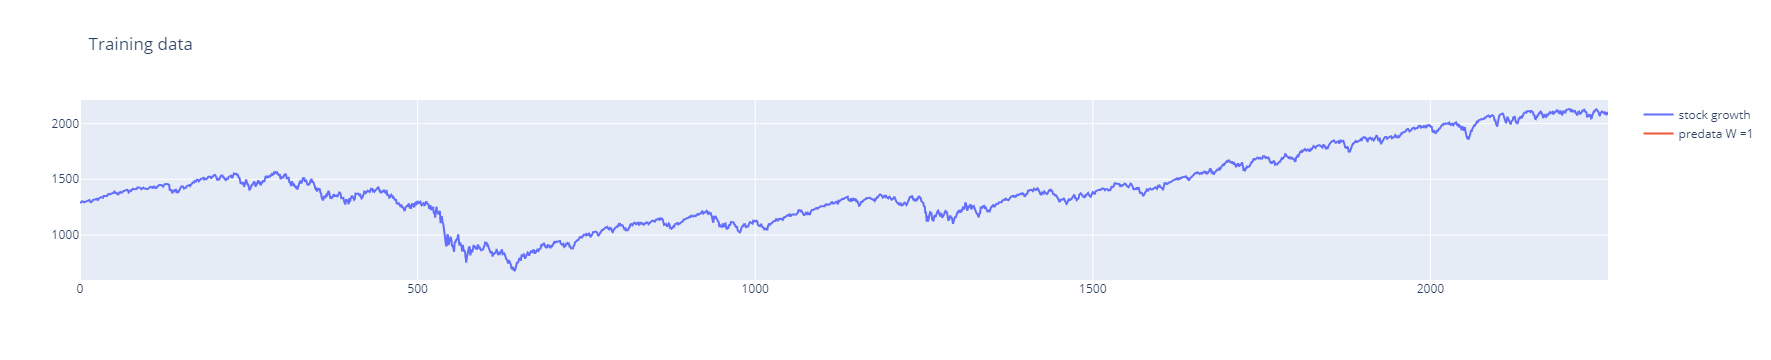

Naive buy & hold strategy on Training data has a portfolio growth of 0.477% per asset bought
For current budget of +$1412.11, this means 1 stocks bought results in a final portfolio growth of +$673.94 (i.e. final value =+$2086.05)


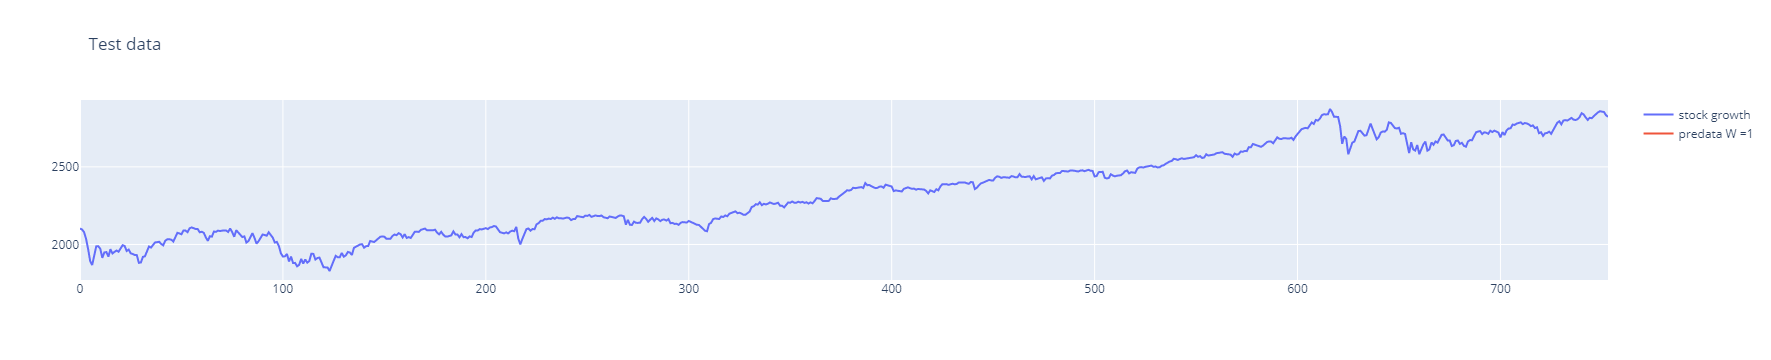

Naive buy & hold strategy on Test data has a portfolio growth of 0.468% per asset bought
For current budget of +$1922.03, this means 1 stocks bought results in a final portfolio growth of +$899.90 (i.e. final value =+$2821.93)


In [6]:
growth_buyhold = UtilFuncs.plot_data(agent, data, data_extra, data_extraWindow, window_size, training = True)
data_val, data_extra_val = UtilFuncs.get_data("validationdata", data_extraWindow, colab = using_colab)
l_val = len(data_val)-1
growth_buyhold_val = UtilFuncs.plot_data(agent, data_val, data_extra_val, data_extraWindow, window_size, training = False)

In [7]:
show_figs = False
debug = False
deadlock_on = False
saveIter = 1
start = 61
episode_count = 3000 #300
use_terminateFunc = True
terminateFunc_on = True
p_start = 1/6  # exploratory probability hack for actions 1 & 2
decay = 0.99
prob = p_start*(decay**(start)) # if we start later in an epoch
switch_episode = 0
#extra_explore = False # whether to override the original exploration sheme
#scaling = 0.1 #0.02
tbzip_folder="/content/{0}_z.zip".format(checkpoint_dir)
zip_folder = "/content/{0}".format(checkpoint_dir)

min_t = window_size 
stats.reset_all(growth_buyhold)
stats_val.reset_all(growth_buyhold_val)


prev_terminate = True
for e in range(start,episode_count):
    agent.is_eval = False # training!
    if e >= switch_episode:
        pbar = tqdm(total=(l-window_size), position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
    #print("== Episode " + str(e) + "/" + str(episode_count) +" ==")
    agent.reset(data[window_size])
    stats.reset_episode()
    pt1 = data_extra[-1]
    sold_price = 0
    bought_price = agent.inventory_value
    utils_state = [l, stats.n_holds,stats.n_trades]
    state = UtilFuncs.get_state(agent, data, window_size, window_size + 1, utils_state)
    
    done = False
    terminate = False
    
    #REWARD TYPE SWITCH EXPERIMENT
    #agent.switch_rewardType(7,switch_episode,e)

    if not prev_terminate:
        if deadlock_on:
            prob = prob*decay # remove
            print("E{0} - Deadlock probability {1}".format(e,prob))
    
    # =============================== ITERATION ======================================================
    for t in range(window_size,l):

        utils_act = [prob,data[t]]
        action, action_prob = agent.act(state, utils_act)
        
        # DEADLOCK EXPERIMENT
        action = UtilFuncs.break_deadlock(agent,action,e,utils_act, on = deadlock_on) 
            
        # Hanle action
        flags = [use_terminateFunc, terminateFunc_on]
        action, profit,  impossible, terminate, term_msg = UtilFuncs.handle_action(agent, stats, action, data, 
                                                                                   t, flags, training = True)
        
        # terminate if required
        if terminate or t == l-1:
            # terminating i.e. last iteration 
            done = True # terminal state has no 'next' so change done variable before use in next lines
            
        # get reward
        if t < data_extraWindow:
            ptn = data_extra[t]
        else: 
            ptn = data[t-data_extraWindow]
        utils_reward = [data[t],pt1, ptn, action, action_prob[0], stats.n_trades, stats.n_holds, impossible, l, terminate]
        reward = agent.get_reward(agent, profit, utils_reward, done)
        stats.total_reward += reward
        pt1 = data[t]
        
        # take step
        utils_state = [l, stats.n_holds,stats.n_trades]
        next_state = UtilFuncs.get_state(agent, data, t + 1, window_size + 1, utils_state)
        actor_local_loss = agent.step(action_prob, reward, next_state, done)
        state = next_state

        # collect 
        utils_saveIter = [profit, reward, actor_local_loss, action]
        stats.collect_iteration(agent,utils_saveIter)
        
        if terminate:
            # ensure consistent length of arrays then terminate trial
            if t >= min_t:
                utils_pad = [l,t]
                stats.pad_on_terminate(utils_pad)    
            print("Episode {0} was terminated at {1}/{2} due to {3}".format(e,t-window_size,l-window_size, term_msg))
            break
        if e >= switch_episode:
            pbar.set_description("Episode {0}| Portfolio: {1}| Balance: {2}| Inventory: {3}| RewardAcc: {4}".format(int(e),
                                                                                                                    UtilFuncs.to_currency(agent.balance+agent.inventory_value),
                                                                                                                    UtilFuncs.to_currency(agent.balance),
                                                                                                                    UtilFuncs.to_currency(agent.inventory_value),
                                                                                                                    UtilFuncs.to_currency(stats.total_reward)))
            pbar.update()

    # ============================ END ITERATION =================================================
    print("E{3} - Amount of impossibles {0}, trades {1} | ratio = {2}".format(stats.n_impossible, 
                                                                              stats.n_1or2-1, 
                                                                              round(stats.n_impossible/stats.n_1or2,3), 
                                                                              e))
    if not terminate:
        # collect & save
        #utils_saveEpi = []
        stats.collect_episode(agent,e, [])
        
    if e % saveIter == 0 and e != 0 and not terminate:
        if not debug:
            # plot and save
            agent.save_models(e)
            utils_fig = [l, window_size]
            stats.plot_figure(data, e, utils_fig, show_figs = show_figs)
            stats.save_statistics(e)
            
            # ================ VALIDATION LOOP ===============================
            stats_val.reset_episode()
            agent.is_eval = True
            agent.reset(data_val[window_size])
            for t in trange(window_size,l_val):
                utils_state = [l_val, stats_val.n_holds,stats_val.n_trades]
                state = UtilFuncs.get_state(agent, data_val, t, window_size + 1, utils_state)
                utils_act = [prob,data_val[t]]
                action, action_prob = agent.act(state, utils_act)

                flags = [use_terminateFunc, terminateFunc_on]
                action, profit,  impossible, terminate, term_msg = UtilFuncs.handle_action(agent, stats_val, action, data_val, 
                                                                                           t, flags, training = False)
                utils_saveIter = [profit, 0., 0., action]
                stats_val.collect_iteration(agent,utils_saveIter)

            stats_val.collect_episode(agent, e, [])
            utils_fig = [l_val, window_size]
            stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)
            # ============= END VALIDATION LOOP =============================
            
        if using_colab and not debug:
            !zip -r "$tbzip_folder" "$zip_folder"
            print("Zip file created, saved next run")
        
    if max(e-1,0) % saveIter == 0 and e != 0 and e != 1 and not debug:
        if not prev_terminate:
            # we skip one iteration as we assume the zip file creation is done now
            if using_colab and not pay: 
                #!zip -r /content/run1_colab_r3v2.zip /content/run1_colab
                #files.download(tbzip_folder)
                shutil.copy(tbzip_folder, "/content/drive/MyDrive")
                #b = 1
                #print("Attempting download, system sleep initiated")
                #time.sleep(24) # Sleep system for x seconds, to give time for download
                #print("System sleep terminated, continueing...")

    '''
    EXPERIMENT
    '''
    if terminate:
        prev_terminate = True
    else:
        prev_terminate = False
            
    #if debug and not terminate:
    #    print("E{3} - Amount of impossibles {0} out of trades {1}, ratio = {2}".format(n_impossible, n_1or2, n_impossible/n_1or2, e))

    

Episode 61| Portfolio: +$1547.70| Balance: +$0.00| Inventory: +$1547.70| RewardAcc: +$0.00:   6%|▋          | 127/2163 C:\Users\Reinier Vos\Documents\YEAR2021_2022\AE MSc C&S\AE4350-Bio_inspiredIntelligenceAndLearning\assignment\scripts\utility_v9.py:448: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

C:\Users\Reinier Vos\Documents\YEAR2021_2022\AE MSc C&S\AE4350-Bio_inspiredIntelligenceAndLearning\assignment\scripts\utility_v9.py:449: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

Episode 61| Portfolio: +$2091.31| Balance: +$7.24| Inventory: +$2084.07

E61 - Amount of impossibles 34, trades 74 | ratio = 0.453


NameError: name 'utils_saveEpi' is not defined

In [8]:
stats_val.reset_episode()
agent.is_eval = True
agent.reset(data_val[window_size])
for t in trange(window_size,l_val):
    utils_state = [l_val, stats_val.n_holds,stats_val.n_trades]
    state = UtilFuncs.get_state(agent, data_val, t, window_size + 1, utils_state)
    utils_act = [prob,data_val[t]]
    action, action_prob = agent.act(state, utils_act)

    flags = [use_terminateFunc, terminateFunc_on]
    action, profit,  impossible, terminate, term_msg = UtilFuncs.handle_action(agent, stats_val, action, data_val, 
                                                                               t, flags, training = False)
    utils_saveIter = [profit, 0., 0., action]
    stats_val.collect_iteration(agent,utils_saveIter)

stats_val.collect_episode(agent, e, [])
utils_fig = [l_val, window_size]
stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)


100%|████████████████████████████████████████████████████████████████████████████████| 653/653 [00:26<00:00, 24.57it/s]


In [ ]:

stats_val.collect_episode(agent, e, [])
utils_fig = [l_val, window_size]
stats_val.plot_figure(data_val, e, utils_fig, show_figs = show_figs)

In [ ]:
# final save
agent.save_models(0)
if using_colab:
    #!zip -r /content/run1_colab_r3v2.zip /content/run1_colab
    !zip -r "$tbzip_folder" "$zip_folder"
    files.download(tbzip_folder)

In [ ]:
# Manually save results
'''
with open(f'./models/{runName}/{runName}_parameters.txt', 'w') as f:
    print(allParameters, file=f)

# Saving results
with open(f'./{checkpoint_dir}/results/total_rewards.npy', 'wb') as f:
    np.save(f, np.array(total_reward_list))
with open(f'./{checkpoint_dir}/results/EveryProfit_dct.json', 'w') as fp:
    json.dump(EveryProfit_dct, fp)
'''

In [ ]:
# loading results
'''
with open(f'./{checkpoint_dir}/total_rewards.npy', 'rb') as f:
    total_reward_list = np.load(f)
with open(f'./{checkpoint_dir}/EveryProfit_dct.json', 'r') as fp:
    EveryProfit_dct = json.load(fp)
'''

In [ ]:
# Setup naive benchmark, buy and hold for training data
test_data, test_data_extra = UtilFuncs.get_data("testdata", data_extraWindow)
data = test_data
data_extra = test_data_extra
fig = pgo.Figure()
fig.update_layout(showlegend=True)
fig.add_trace(pgo.Scatter(x=np.arange(len(test_data)), y=test_data,
                    mode='lines',
                    name='stock growth'))
fig.add_trace(pgo.Scatter(x=np.arange(len(test_data_extra)), y=test_data_extra,
                    mode='lines',
                    name='stock MA adjusted W ={}'.format(data_extraWindow)))
fig.show()
growth_buyhold_per = (data[-1]-data[window_size])/data[window_size]

print("Naive buy & hold strategy on TEST data has a portfolio growth of {0}% per asset bought at the start of 2015 and sold at 2018".format(round(growth_buyhold_per,3)))
growth_buyhold_cash = agent.n_budget*data[window_size]*growth_buyhold_per
growth_buyhold = (agent.n_budget*(data-data[window_size]))[window_size:-1]
print("For current budget of {0}, this means that for {1} stocks bought in 2015 and sold in 2018 one achieves a final portfolio growth of {2}".format(UtilFuncs.to_currency(agent.n_budget*data[window_size]),agent.n_budget,UtilFuncs.to_currency(growth_buyhold_cash)))

In [ ]:
#load_dir = "runs/colab/content/run1_colab_noPTcont"
load_dir = "runs/colab/content/run1_v6_prftAdj+holdbonus25"
try:
    agent.setup_validation(load_dir)
except:
    pass
checkpoint_dir = load_dir
val_episode = 20
agent.load_models(load_dir,val_episode)
agent.load_attributes(load_dir)

In [ ]:
# Validation cell
data = test_data # sanity check
data_extra = test_data_extra
l = len(data) - 1
l1 = 2263
agent.is_eval = True #True
extraCash = 0
showfigs = True
deadlock_on = False # must remain off!
debug = False
use_terminateFunc = True
terminateFunc_on = False
prob = 0 # not used
# initialize and container setup
agent.reset(data[window_size])
agent.validation_extraCash(extraCash) # function must be after reset!
total_reward = 0 # total profit resets every epsiode 
n_trades = 0 
n_impossible = 0 
n_holds = 0 
n_1or2 = 1 # 1 not zero because we cant have division by zero 
profits = []
balances = []
rewards = []
inventories = [] # inventory value (only stocks)
actor_local_losses = []
buy_ind = []
sell_ind = []
utils_state = [l1, n_holds, n_trades]
state = UtilFuncs.get_state(agent, data, window_size, window_size + 1, utils_state)
pt1 = data_extra[-1]

pbar = tqdm(total=l, position=0, leave=True, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ') # progress bar
fig = pgo.Figure()
fig.update_layout(showlegend=True)
done = False
terminate = False

for t in range(window_size,l):
    profit = 0 # initialize
    change = 0 
    impossible = False
    utils_act = [prob,data[t]]
    action, action_prob = agent.act(state, utils_act)

    # DEADLOCK EXPERIMENT
    #action = UtilFuncs.break_deadlock(agent,action,e,utils_act, on = deadlock_on) 

    # =========================== ACTION SPACE ======================================
    if action == 0:
        n_holds += 1

    elif action == 1:
        n_1or2 += 1
        
        if len(agent.inventory) == 0: #max one stock 
            if agent.balance > data[t]:
                # BUYING stock, only if there is balance though
                agent.inventory.append(data[t])
                sold_price = agent.inventory_conj.pop(0)

                profit = sold_price - data[t]

                change = -data[t]
                buy_ind.append(t)
                n_trades += 1
                n_holds = 0 # reset counter
            else: 
                extraCash += data[t] - agent.balance
                agent.reset(data[t])
        else:
            impossible = True
            n_impossible += 1
            n_holds += 1 # effectively no buy is a hold
            if not use_terminateFunc:
                terminate = True

    elif action == 2:
        n_1or2 += 1
        if len(agent.inventory) > 0: 
            # SELLING stock, only if there are stocks held

            bought_price = agent.inventory.pop(0)
            agent.inventory_conj.append(data[t])

            profit = data[t] - bought_price 

            change = data[t]
            sell_ind.append(t)
            n_trades += 1
            n_holds = 0 # reset counter
        else:
            impossible = True
            n_impossible += 1
            n_holds += 1 # effectively no sell is a hold
            if not use_terminateFunc:
                terminate = True
    # =============================== END ======================================

    agent.update_balance(change)
    agent.update_inventory(data[t])
    if use_terminateFunc:
        utils_term = [n_impossible, np.min(data[(t+1):])]
        terminate = agent.check_threshold(utils_term, terminateFunc_on= terminateFunc_on)
        #terminate = agent.check_threshold()
    if terminate or t == l-1:
        # terminating i.e. last iteration 
        done = True # terminal state has no 'next' so change done variable before use in next lines


    if t < data_extraWindow:
        ptn = data_extra[t]
    else: 
        ptn = data[t-data_extraWindow]
    utils_reward = [data[t],pt1, ptn, action, n_trades, n_holds, impossible, l, terminate]
    pt1 = data[t]
    '''
    change names of variables if it works
    '''
    reward = agent.get_reward(agent, profit, utils_reward, done)
    total_reward += reward

    utils_state = [l, n_holds,n_trades]
    next_state = UtilFuncs.get_state(agent, data, t + 1, window_size + 1, utils_state)

    #actor_local_loss = agent.step(action_prob, reward, next_state, done)
    state = next_state

    # collect 
    balances.append(agent.balance)
    inventories.append(agent.inventory_value)
    profits.append(profit)
    rewards.append(reward)
    #actor_local_losses.append(float(actor_local_loss))
    
    if terminate:
        # ensure consistent length of arrays then terminate trial
        if t >= 1500:
            balances = np.pad(balances,(0,l-t-1),'constant',constant_values=(0,balances[-1])).tolist()
            inventories = np.pad(inventories,(0,l-t-1),'constant',constant_values=(0,inventories[-1])).tolist()
            profits = np.pad(profits,(0,l-t-1),'constant',constant_values=(0,0)).tolist()
            rewards = np.pad(rewards,(0,l-t-1),'constant',constant_values=(0,0)).tolist()
            #actor_local_losses = np.pad(actor_local_losses,(0,l-t-1),'constant',constant_values=(0,actor_local_losses[-1])).tolist()
        print("Episode {0} was terminated at {1}/{2} due to terminal state".format('test',t,l))
        break

    pbar.set_description("VALIDATION e{4}| Portfolio: {0}| Balance: {1}| Inventory: {2}| RewardAcc: {3}".format(UtilFuncs.to_currency(agent.balance+agent.inventory_value),
                                                                                                            UtilFuncs.to_currency(agent.balance),
                                                                                                            UtilFuncs.to_currency(agent.inventory_value),
                                                                                                            UtilFuncs.to_currency(total_reward),
                                                                                                            val_episode))
    pbar.update()

        
    

    # collect & save
growth = (np.array(balances)+np.array(inventories)-agent.budget).tolist() # 
compete = (np.array(growth)-growth_buyhold).tolist() # compete vs buyhold
print("Amount of impossibles {0}, trades {1} (+1!)| ratio = {2}".format(n_impossible, n_1or2, n_impossible/n_1or2))
fig.update_layout(showlegend=True, xaxis_range=[window_size, l], 
                  title_text = "Test e{5} | profit RL: {0} vs buyhold: {1}, difference = {2} | extra cash = {3}| Impossible ratio {4}".format(round(growth[-1],2),
                                                                                                                     round(growth_buyhold[-1],2),
                                                                                                                     round(growth[-1]-growth_buyhold[-1],2),
                                                                                                                     extraCash,
                                                                                                                     round(n_impossible/n_1or2,3),
                                                                                                                     val_episode))
fig.add_trace(pgo.Scatter(x=np.arange(len(data)), y=data,
                    mode='lines',
                    name='data'))
fig.add_trace(pgo.Scatter(x=buy_ind, y=data[buy_ind], marker_color = "green",
                    mode='markers',
                    name='buy'))
fig.add_trace(pgo.Scatter(x=sell_ind, y=data[sell_ind], marker_color = "red",
                    mode='markers',
                    name='sell'))
if showfigs:
    fig.show(render = "browser")
fig.write_html("./{0}/validation/e{1}_tradesTest.html".format(checkpoint_dir,val_episode))
    
# collect & save
save_df = {"balance":balances,"inventory":inventories,"profit":profits,"reward":rewards,"growth":growth,"compete":compete,"growth_buyhold":growth_buyhold.tolist()}
save_df = pd.DataFrame(save_df).to_csv("./{0}/validation/e{1}_testResults.csv".format(checkpoint_dir,val_episode))
print("Succesfully saved csv file")



In [ ]:
extraCash

In [ ]:
utils_state = [l, n_holds]
t = 99
state = UtilFuncs.get_state(agent, data, t, window_size + 1, utils_state)
utils_act = [prob,data[t]]
state[0][0:] = 0.5 
state[0][-5] = -0.2 # bal
state[0][-4] = -0.3 # invent
state[0][-3] = -0.3 # port
state[0][-2] = 0.8 # hold
state[0][-1] = 0. # holdin
print(state[0])

In [ ]:
action, action_prob = agent.act(state, utils_act)
action_prob

In [ ]:
## Plotting RL vs buyhold
fig = pgo.Figure()
fig.update_layout(showlegend=True)
fig.add_trace(pgo.Scatter(x=np.arange(len(growth)), y=np.array(growth),
                    mode='lines',
                    name='growth_RL'))
fig.add_trace(pgo.Scatter(x=np.arange(len(growth)), y=np.array(growth_buyhold),
                    mode='lines',
                    name='growth_buyhold'))
fig.add_trace(pgo.Scatter(x=buy_ind, y=data[buy_ind], marker_color = "green",
                    mode='markers',
                    name='buy'))
fig.add_trace(pgo.Scatter(x=sell_ind, y=data[sell_ind], marker_color = "red",
                    mode='markers',
                    name='sell'))
fig.show()

# testing whether model even learnt
model1 = Agent(window_size, batch_size)
model1 = model1.critic_target.model
a= model1.get_weights()
print(a[10])
print("=================================")
model2 = Agent(window_size, batch_size)
model2.critic_target.model.load_weights("./run1/e203/critic_local.h5")
b =model2.critic_target.model.get_weights()
print(b[10])

In [ ]:
growth_buyhold[100]